In [18]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [19]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0



In [22]:
df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

In [23]:
left_glaucoma= df.loc[df.G ==1]["Left-Fundus"].values
left_glaucoma[:15]

array(['43_left.jpg', '95_left.jpg', '153_left.jpg', '167_left.jpg',
       '178_left.jpg', '238_left.jpg', '247_left.jpg', '365_left.jpg',
       '583_left.jpg', '625_left.jpg', '746_left.jpg', '931_left.jpg',
       '1209_left.jpg', '1210_left.jpg', '1211_left.jpg'], dtype=object)

In [24]:
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [25]:
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

Number of images in left glaucoma: 397
Number of images in right glaucoma: 284


In [26]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [27]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [28]:
print(len(glaucoma),len(normal))


681 500


In [29]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/project image/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)

  
    return dataset

In [30]:
dataset = []
dataset = create_dataset(glaucoma,1)

100%|██████████| 681/681 [04:35<00:00,  2.47it/s] 


In [31]:
len(dataset)

673

In [32]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [06:06<00:00,  1.37it/s]


In [33]:
len(dataset)

1173

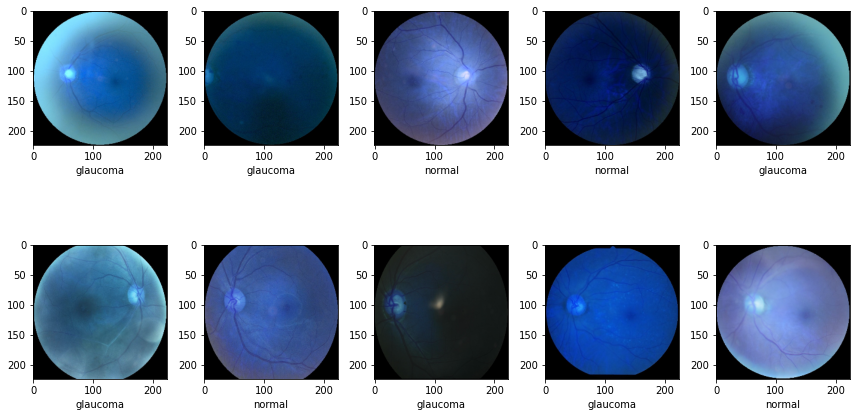

In [34]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "normal"
    else:
        label = "glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [35]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [36]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [37]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
vgg = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(224,224,3)
)
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
    )


resnet101 = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
    )


171446536/171446536 [==============================] - 8s 0us/step


In [38]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense
model1 = Sequential()
model1.add(vgg)
model1.add(Dense(256, activation='relu'))
model1.add(layers.Dropout(rate=0.5))
model1.add(Dense(128, activation='relu'))
model1.add(layers.Dropout(rate=0.2))
model1.add(Dense(128, activation='relu'))
model1.add(layers.Dropout(0.1))
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid"))

In [39]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 256)         131328    
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 dense_2 (Dense)             (None, 7, 7, 128)         16512     
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0

In [40]:
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [54]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience = 10)
hist1 = model1.fit(x_train,y_train,batch_size=100,epochs=1000,validation_split=0.2, callbacks = [early_stopping])

Epoch 1/1000
8/8 [==============================] - 11s 1s/step - loss: 0.6849 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 2/1000
8/8 [==============================] - 11s 1s/step - loss: 0.6846 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 3/1000
8/8 [==============================] - 11s 1s/step - loss: 0.6849 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 4/1000
8/8 [==============================] - 12s 1s/step - loss: 0.6855 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 5/1000
8/8 [==============================] - 12s 1s/step - loss: 0.6850 - accuracy: 0.5640 - val_loss: 0.6864 - val_accuracy: 0.5585
Epoch 6/1000
8/8 [==============================] - 12s 1s/step - loss: 0.6849 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 7/1000
8/8 [==============================] - 12s 1s/step - loss: 0.6850 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 8/1000
8/8 [==

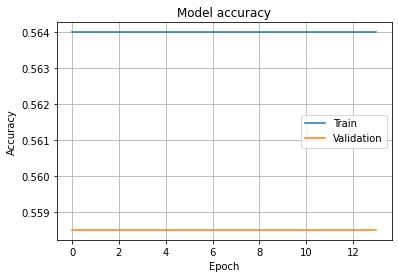

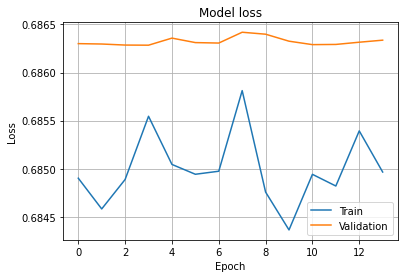

In [55]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

In [42]:
model2 = Sequential()
model2.add(resnet50)
model2.add(Flatten())
model2.add(Dense(1,activation="sigmoid"))


In [43]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 23,634,945
Non-trainable params: 53,120
_________________________________________________________________


In [44]:
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [45]:
early_stopping = EarlyStopping(patience = 30)
hist2 = model2.fit(x_train,y_train,batch_size=100,epochs=1000,validation_split=0.2, callbacks = [early_stopping])

Epoch 1/1000
8/8 [==============================] - 22s 2s/step - loss: 6.6634 - accuracy: 0.6320 - val_loss: 317.9175 - val_accuracy: 0.5585
Epoch 2/1000
8/8 [==============================] - 8s 964ms/step - loss: 2.2072 - accuracy: 0.7293 - val_loss: 199.9892 - val_accuracy: 0.4415
Epoch 3/1000
8/8 [==============================] - 8s 980ms/step - loss: 2.0840 - accuracy: 0.6987 - val_loss: 215.2231 - val_accuracy: 0.5585
Epoch 4/1000
8/8 [==============================] - 8s 968ms/step - loss: 2.5773 - accuracy: 0.7213 - val_loss: 6225969.0000 - val_accuracy: 0.4521
Epoch 5/1000
8/8 [==============================] - 8s 963ms/step - loss: 1.6238 - accuracy: 0.6613 - val_loss: 89382.7031 - val_accuracy: 0.4415
Epoch 6/1000
8/8 [==============================] - 8s 962ms/step - loss: 1.5642 - accuracy: 0.6893 - val_loss: 117427.6953 - val_accuracy: 0.4415
Epoch 7/1000
8/8 [==============================] - 8s 965ms/step - loss: 1.1205 - accuracy: 0.6653 - val_loss: 45593.4453 - val_

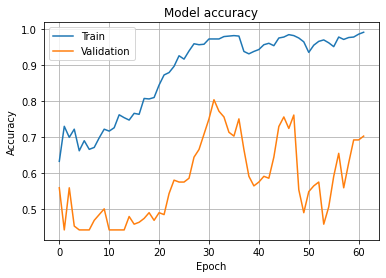

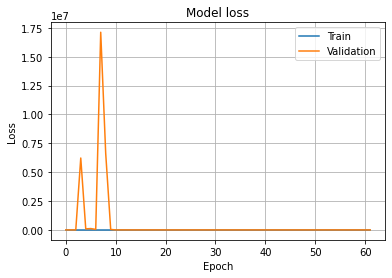

In [46]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

In [47]:
model3 = Sequential()
model3.add(resnet101)
model3.add(Flatten())
model3.add(Dense(1,activation="sigmoid"))

In [48]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 42,758,529
Trainable params: 42,653,185
Non-trainable params: 105,344
_________________________________________________________________


In [49]:
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [51]:
early_stopping = EarlyStopping(patience = 30)
hist3 = model3.fit(x_train,y_train,batch_size=80,epochs=1000,validation_split=0.2, callbacks = [early_stopping])

Epoch 1/1000
10/10 [==============================] - 19s 2s/step - loss: 4.8050 - accuracy: 0.5667 - val_loss: 1970258444288.0000 - val_accuracy: 0.5585
Epoch 2/1000
10/10 [==============================] - 13s 1s/step - loss: 1.9501 - accuracy: 0.6280 - val_loss: 17996034605056.0000 - val_accuracy: 0.5532
Epoch 3/1000
10/10 [==============================] - 13s 1s/step - loss: 2.0181 - accuracy: 0.5867 - val_loss: 11658683356282880.0000 - val_accuracy: 0.4415
Epoch 4/1000
10/10 [==============================] - 13s 1s/step - loss: 2.4897 - accuracy: 0.5640 - val_loss: 55244679544832.0000 - val_accuracy: 0.5585
Epoch 5/1000
10/10 [==============================] - 13s 1s/step - loss: 1.9320 - accuracy: 0.5640 - val_loss: 152480918798336.0000 - val_accuracy: 0.5585
Epoch 6/1000
10/10 [==============================] - 13s 1s/step - loss: 1.8288 - accuracy: 0.5693 - val_loss: 547771678720.0000 - val_accuracy: 0.4415
Epoch 7/1000
10/10 [==============================] - 13s 1s/step - l

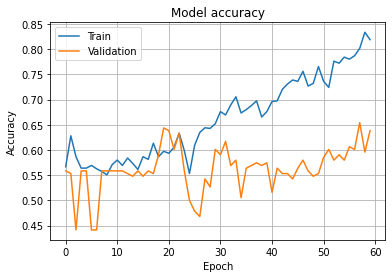

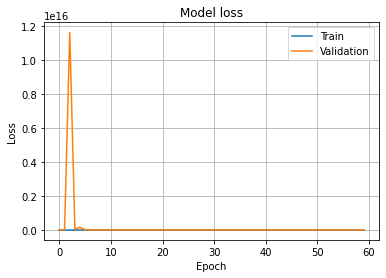

In [52]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

In [56]:
#모델 정확도 비교
# vgg16
new_model1 = model1
loss,accuracy = new_model1.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)
#resnet50
new_model2 = model2
loss,accuracy = new_model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)
#resnet101
new_model3 = model3
loss,accuracy = new_model3.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

8/8 [==============================] - 1s 134ms/step - loss: 0.6714 - accuracy: 0.6170
loss: 0.6713763475418091
Accuracy: 0.6170212626457214
8/8 [==============================] - 1s 83ms/step - loss: 1.4849 - accuracy: 0.7702
loss: 1.4849404096603394
Accuracy: 0.7702127695083618
8/8 [==============================] - 1s 139ms/step - loss: 2.4056 - accuracy: 0.6851
loss: 2.4056057929992676
Accuracy: 0.6851063966751099
